In [1]:
include("SpinGlassCore.jl")
using .SpinGlassCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, Random, ProgressMeter
using CairoMakie

# seed = 42
# Random.seed!(seed)

init_logger(dir="../../logs", level=:Info)
println(names(SpinGlassCore))

[:SpinGlassCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [2]:
N = 20
β_min = 0.1
β_max = 2
M = 20
η = 0.001
mcSteps=10^4
eqSteps=10^4
# target = 0.23
epochs = 300
batch_size = 10
Jh = rand([-1.0, 1.0], N, N)
Jv = rand([-1.0, 1.0], N, N)
@info L"""
Hyperparameters of ±J model:
--------------------
system size: %$(N*N),
the number of replica: %$M,
MCS: %$mcSteps
Jh: %$Jh,
Jv: %$Jv,
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
exchange_prob_means, _ = SpinGlassCore.calc_acceptance_and_rtt(N, init_β_ladder, Jh, Jv)

println(init_β_ladder)
println(exchange_prob_means)

[0.10000000000000017, 0.11707799137227812, 0.13707256063767206, 0.16048180071713414, 0.18788886879768257, 0.21997651360042134, 0.2575440836141391, 0.301527439993574, 0.353022270180727, 0.4133113830244113, 0.4838966653579629, 0.5665364961185363, 0.6632895500464655, 0.776566082176622, 0.9091879706907822, 1.0644590138831427, 1.2462472324355405, 1.4590812272681344, 1.7082629933755134, 2.0]
[0.7358473523023655, 0.6951470478799926, 0.6322773169811648, 0.590816712808734, 0.5286966042839196, 0.4578503548710746, 0.3823943383565289, 0.3190203512800528, 0.25730535816503913, 0.1988393149039772, 0.16200406044532964, 0.12747367138944388, 0.13539262093986587, 0.1622215547134194, 0.21261129994590275, 0.27802605172063855, 0.3984297169601018, 0.5480672278449173, 0.7420487467030822]


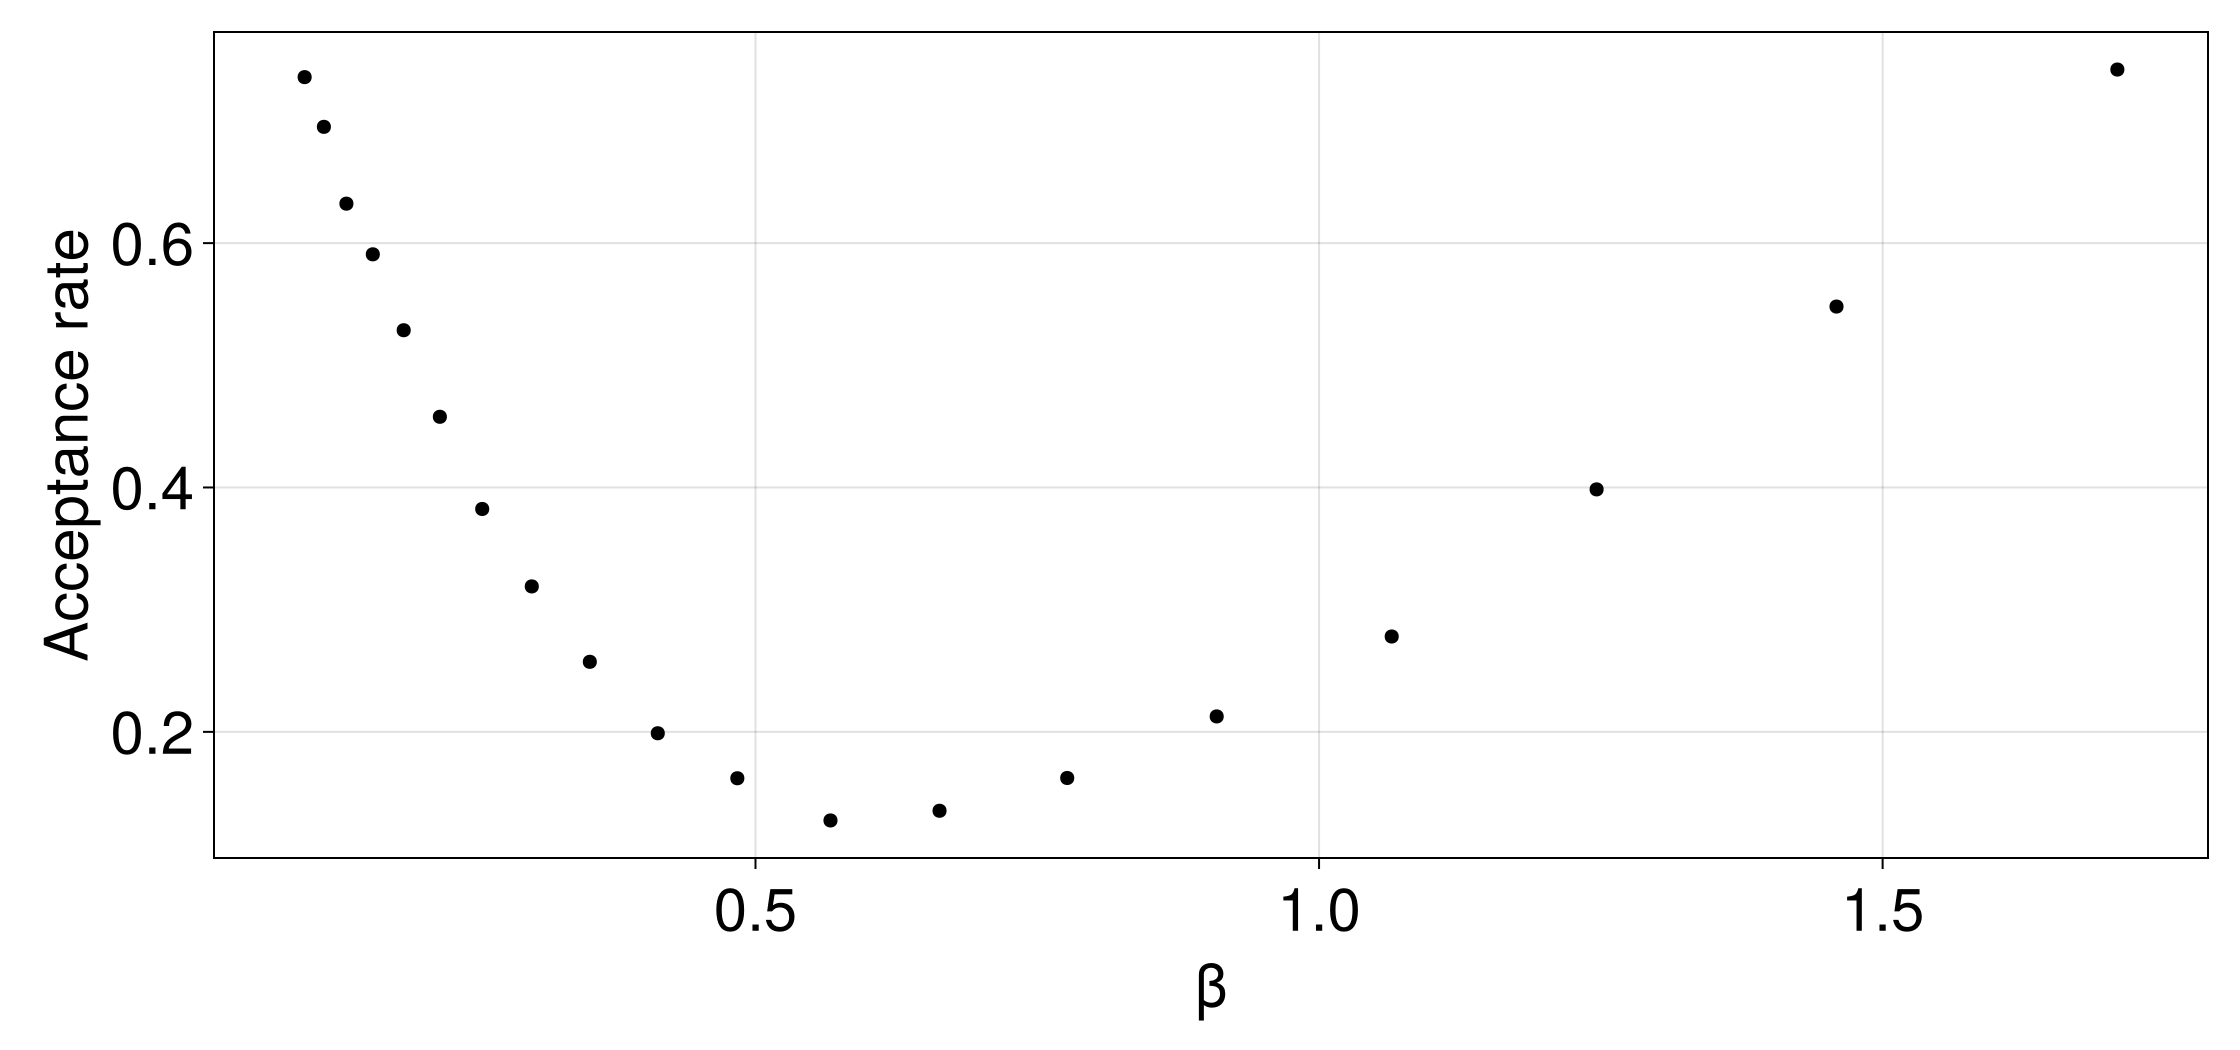

CairoMakie.Screen{IMAGE}


In [4]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, init_β_ladder[1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [5]:
β_ladder = deepcopy(init_β_ladder)
β_ladder_trace = [β_ladder]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β_ladder)

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = SpinGlassCore.score_method(
            N, 
            β_ladder,
            Jh,
            Jv;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    grad_mean[end] = 0.0
    setup, β_ladder = Optimisers.update(setup, β_ladder, grad_mean)

    push!(β_ladder_trace, deepcopy(β_ladder))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 4:26:24


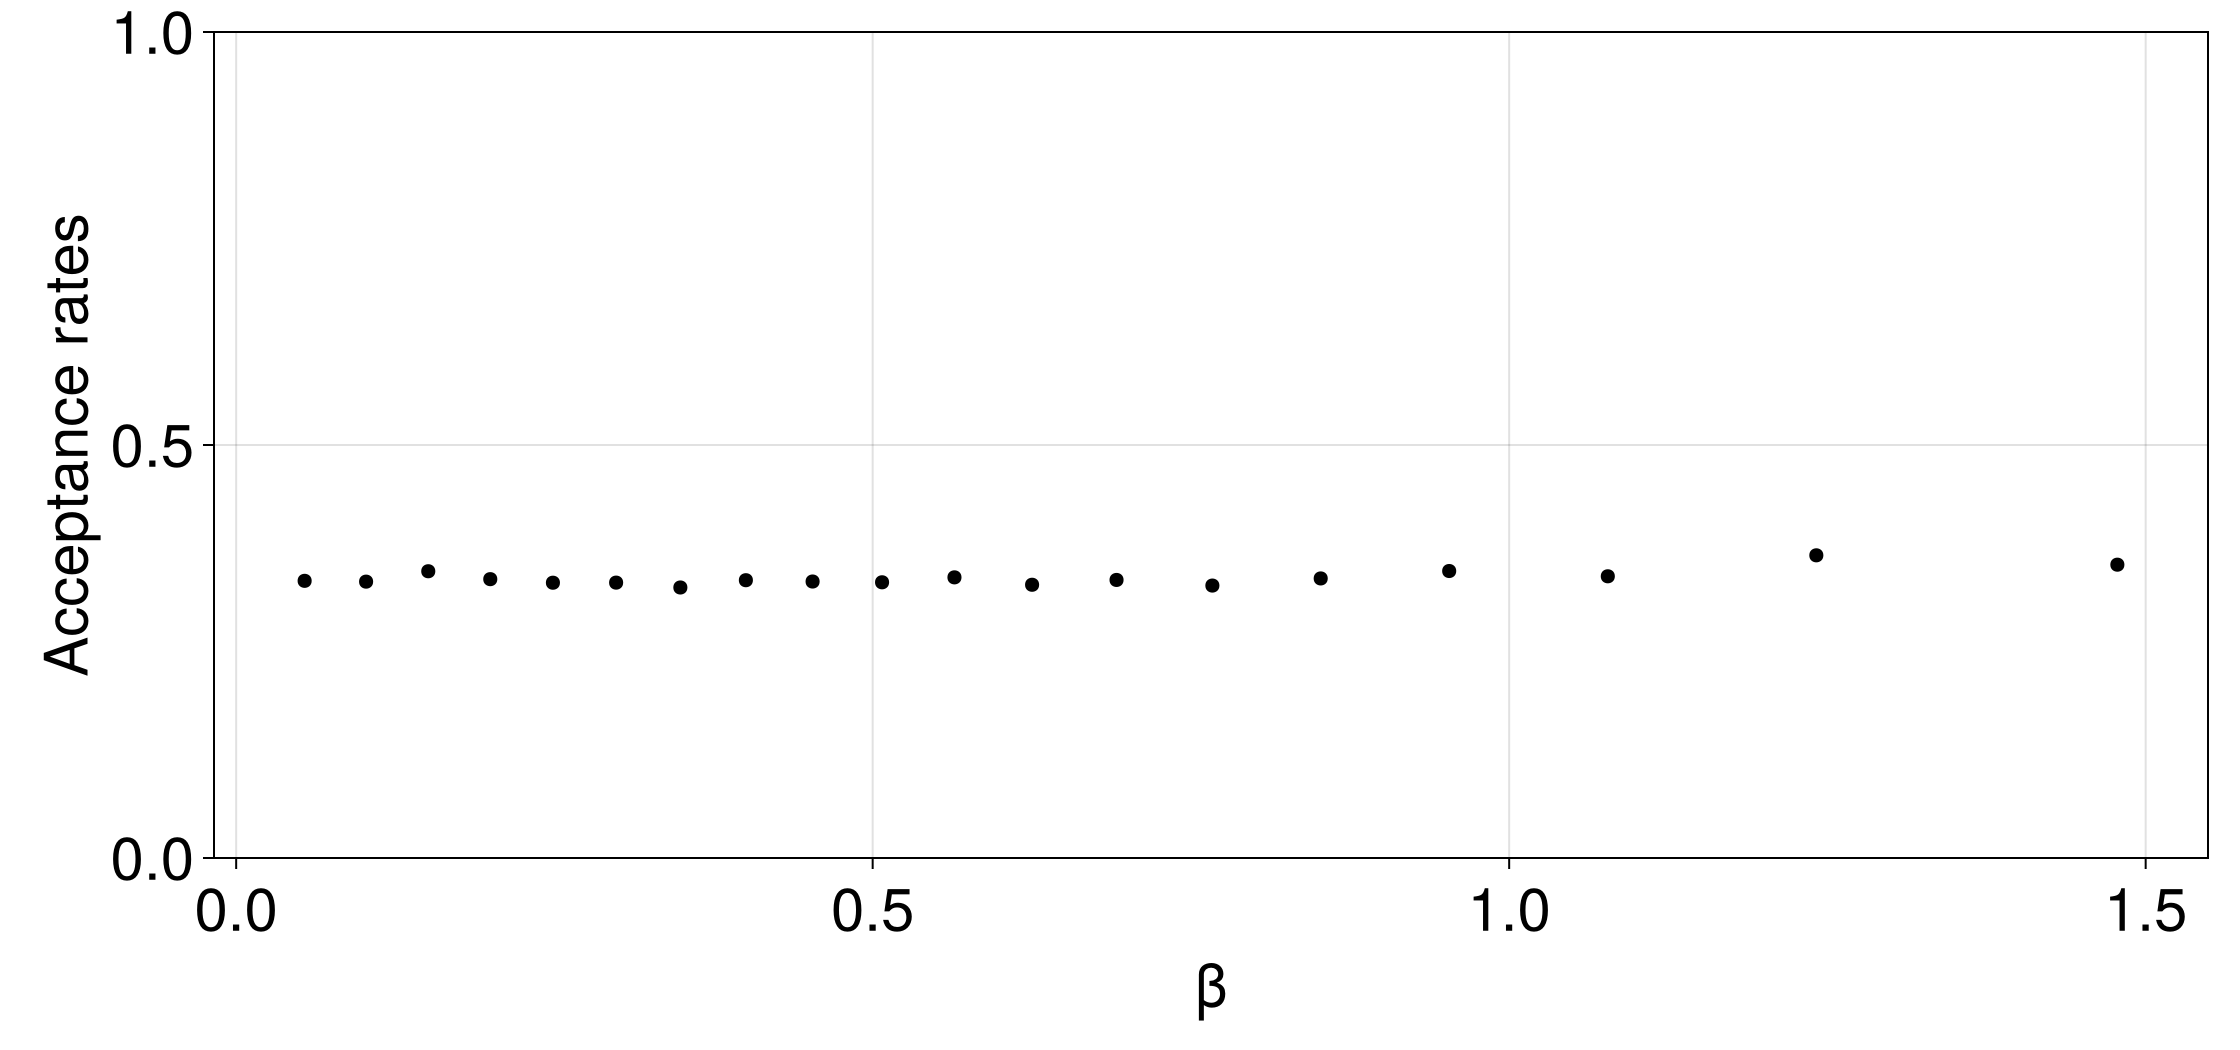

CairoMakie.Screen{IMAGE}


In [6]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rates")
ylims!(ax1, 0, 1)
scatter!(ax1, β_ladder_trace[end][1:(end-1)], exchange_prob_trace[end], color=:black, markersize=10)

display(fig1)

In [7]:
dir = "../../plots/Edwards-Anderson_model_2d/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/Edwards-Anderson_model_2d/L=20/M=20"

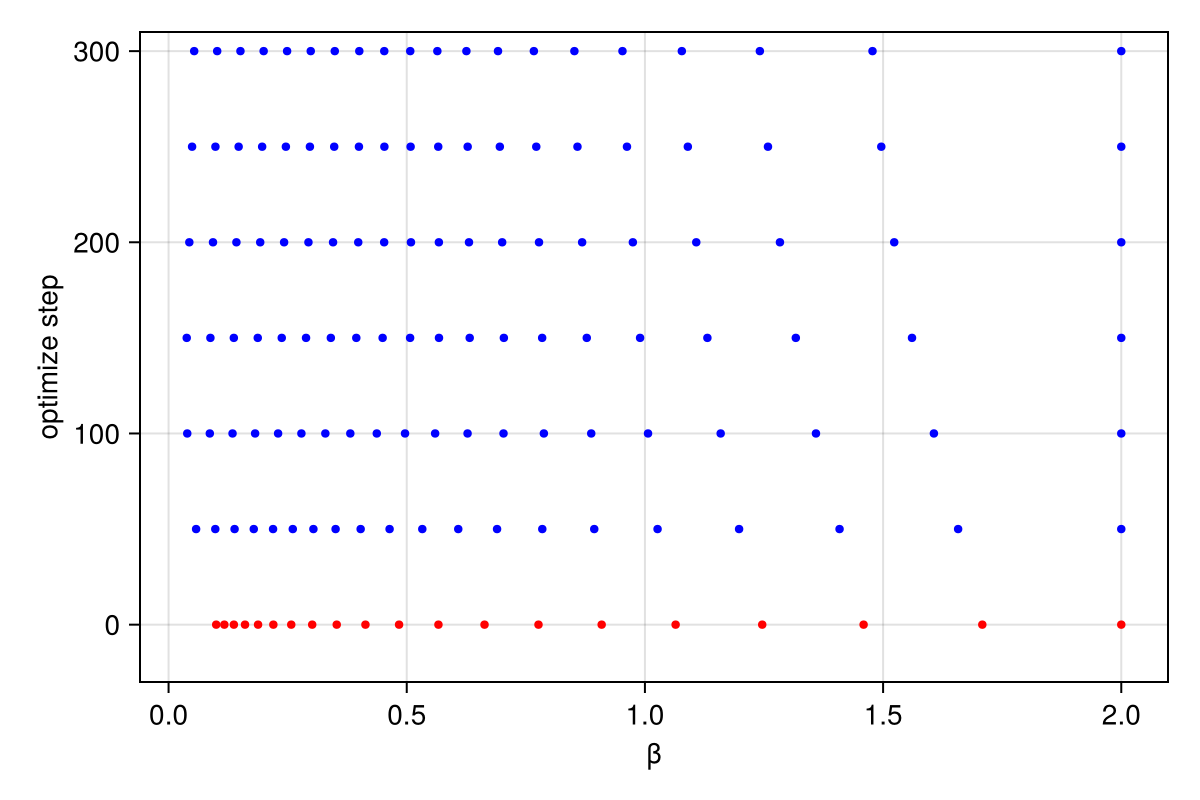

In [8]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step"
)
# xlims!(ax, -0.05, 2.05)
ylims!(ax, -30, epochs+10)

plot_interval = 50
for (i, β_ladder) in enumerate(β_ladder_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_ladder
        y_values = fill(step, length(β_values))
        marker_color = (step == 0) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end

display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

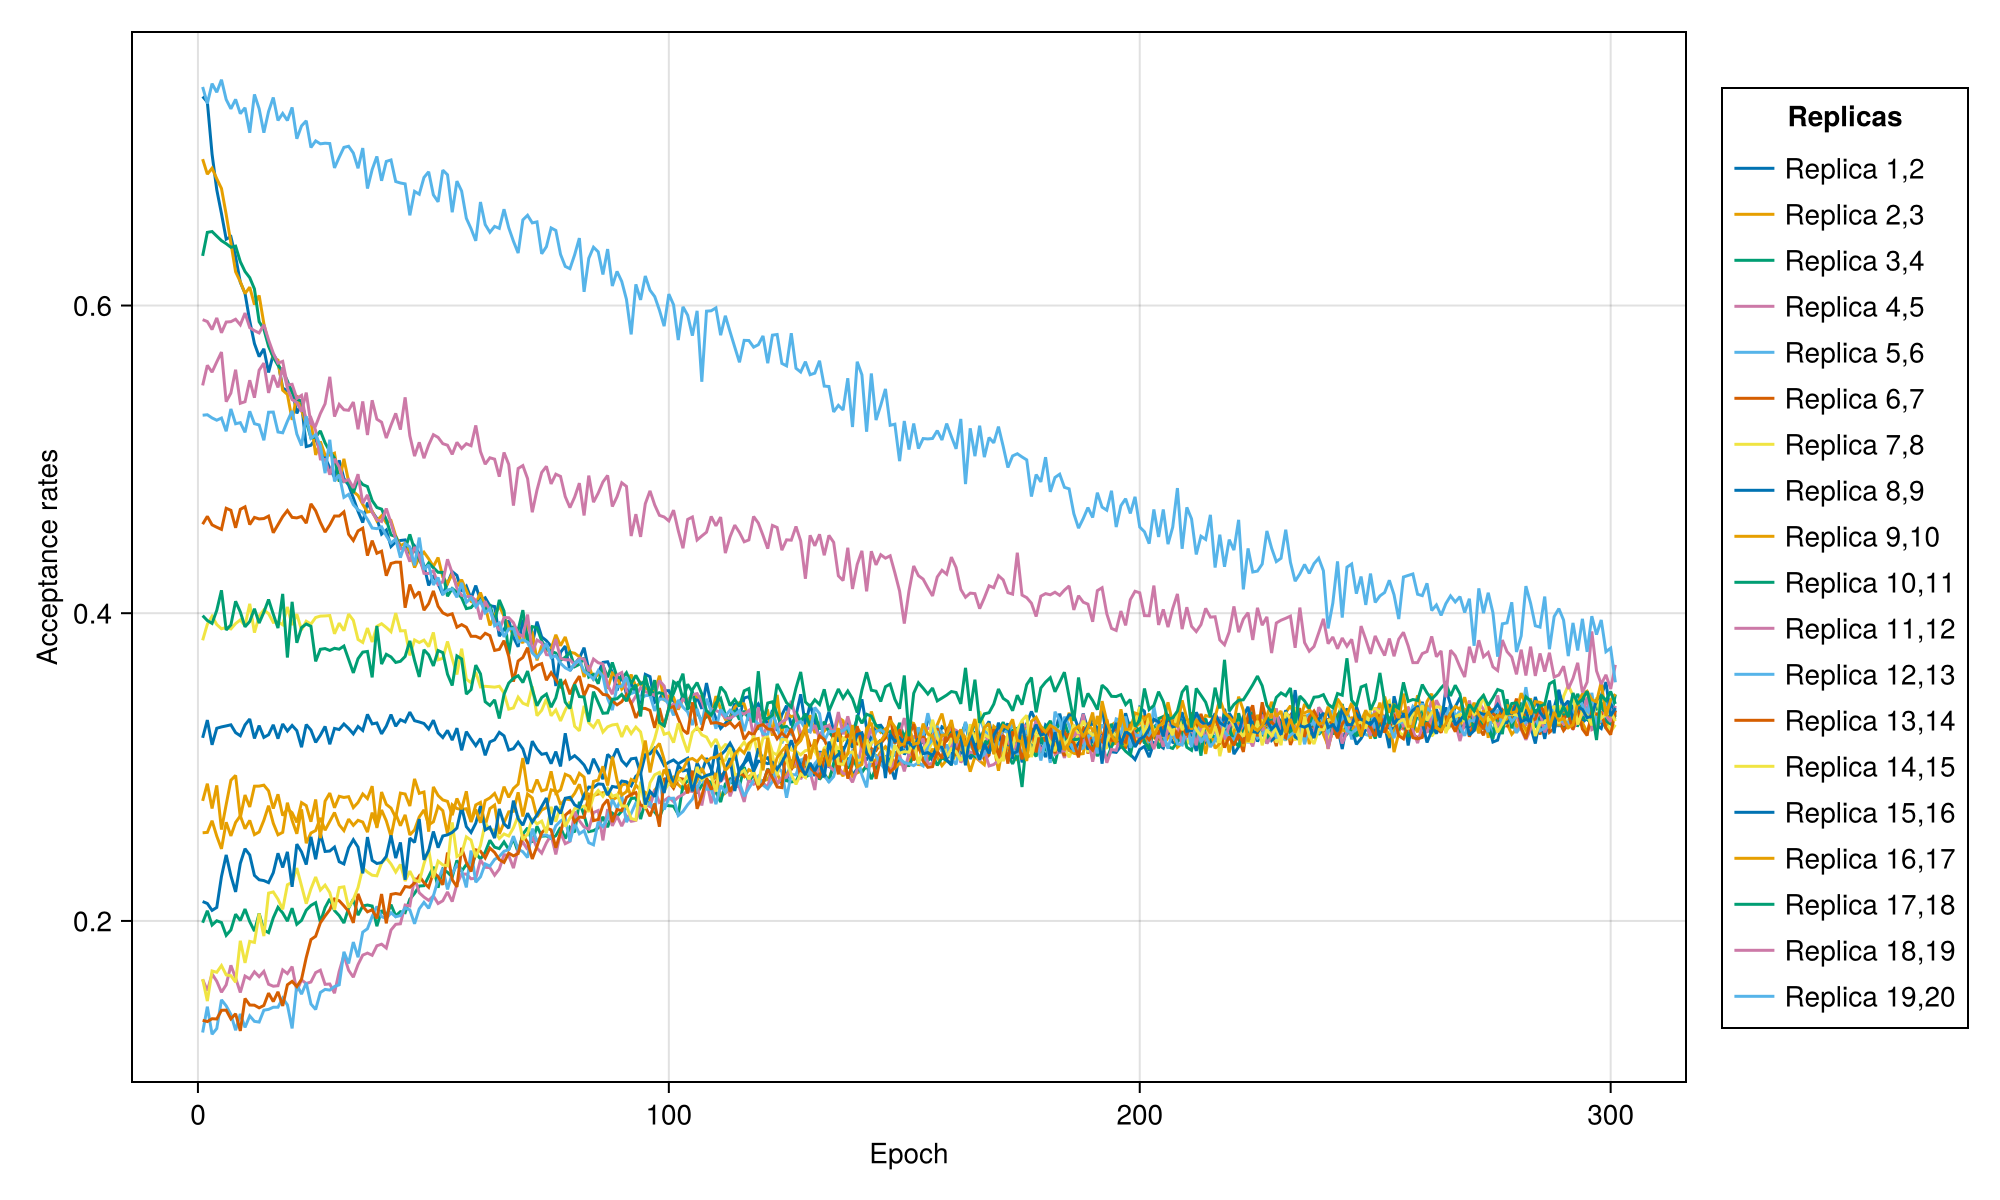

In [9]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates"
)
# ylims!(ax2, 0, 1)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

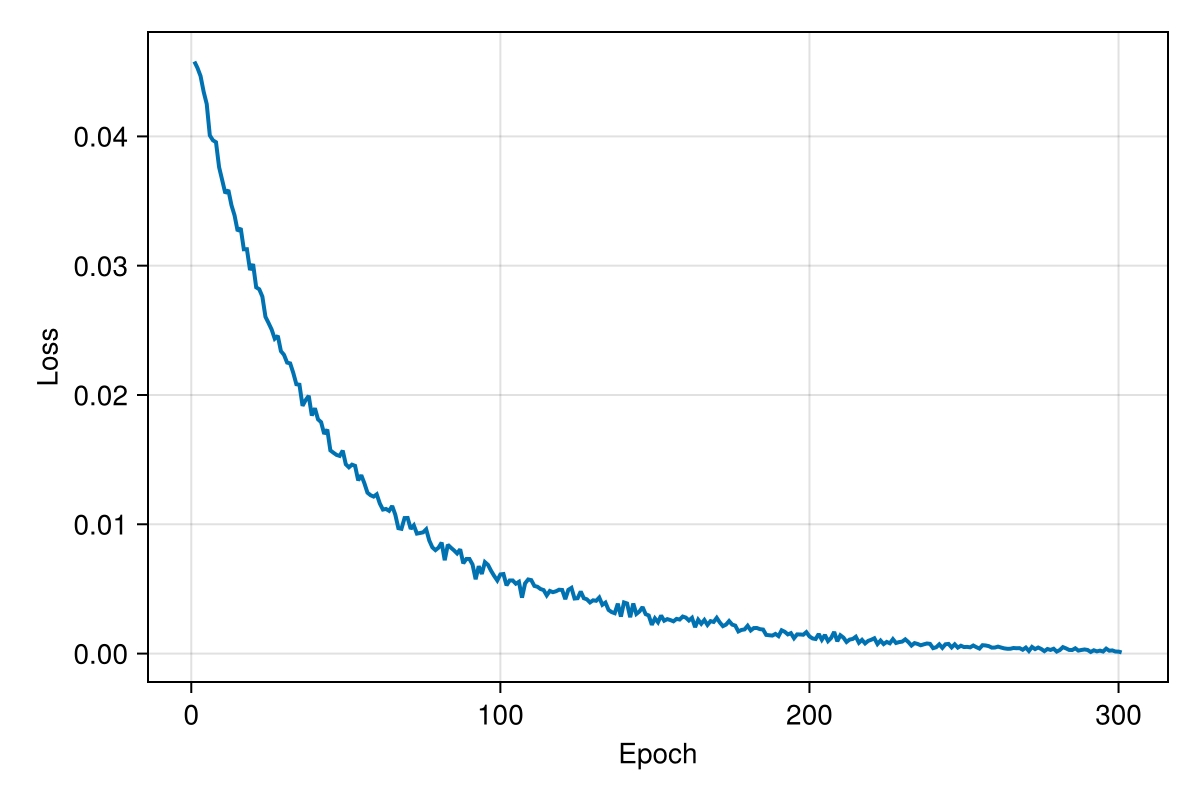

In [10]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [11]:
println(β_ladder_trace[end])

[0.053786393409091186, 0.10206416297342975, 0.1509017285690582, 0.19960876485859932, 0.24882411523699202, 0.29847075385098154, 0.34893314958004823, 0.40039980478204007, 0.4528107018646845, 0.5073824209278873, 0.5642520797494198, 0.6252354820112133, 0.6915706264129888, 0.7668586760774677, 0.8519549422559143, 0.9528828864788209, 1.0774843566287091, 1.241288355831627, 1.4777670352104888, 2.0]
